# Generate datasets to train CNNs to identify number of layers in the time domain

In [1]:
import torch
from concurrent.futures import ProcessPoolExecutor
import numpy as np
import matplotlib.pyplot as plt
from Simulate import simulate_reference, simulate_parallel

c = 299792458   


def downsample_tensor(tensor, factor):
    """
    Downsamples a 1D tensor by the given factor by taking every nth sample.
    
    Args:
        tensor (torch.Tensor): The input 1D tensor.
        factor (int): The downsampling factor.
        
    Returns:
        torch.Tensor: The downsampled tensor.
    """
    if len(tensor.shape) != 1:
        raise ValueError("Input tensor must be 1D")
    return tensor[::factor]

[((3.46-0.01j), 0.0007), ((2.5-0.015j), 0.0005)]


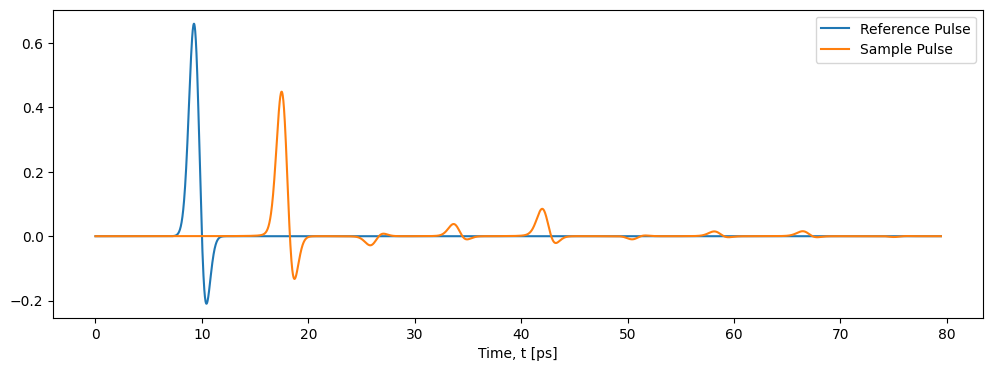

In [2]:
# Define Example parameters
deltat = 0.0194e-12  # Time step
L = 2**12  # Number of time points

# Generate reference pulse
reference_pulse = simulate_reference(L, deltat)

n1, k1, d1 = 3.46, -0.01, 0.7e-3
n2, k2, d2= 2.5, -0.015, 0.5e-3

# Experimental material parameters (ground truth)
material_params_exp = [(n1+1j*k1, d1), (n2+1j*k2, d2)]


# Simulate the experimental data
t_axis = np.arange(0, L * deltat, deltat)
_, experimental_pulse = simulate_parallel(reference_pulse, material_params_exp, deltat, noise_level=0)
experimental_pulse = experimental_pulse[:L]
experimental_pulse = experimental_pulse.detach().cpu()

print(material_params_exp)
plt.figure(figsize=(12,4))
plt.plot(t_axis*1e12, reference_pulse, label= 'Reference Pulse')
plt.plot(t_axis*1e12, experimental_pulse, label= 'Sample Pulse')
plt.xlabel('Time, t [ps]')
plt.legend()
plt.show()

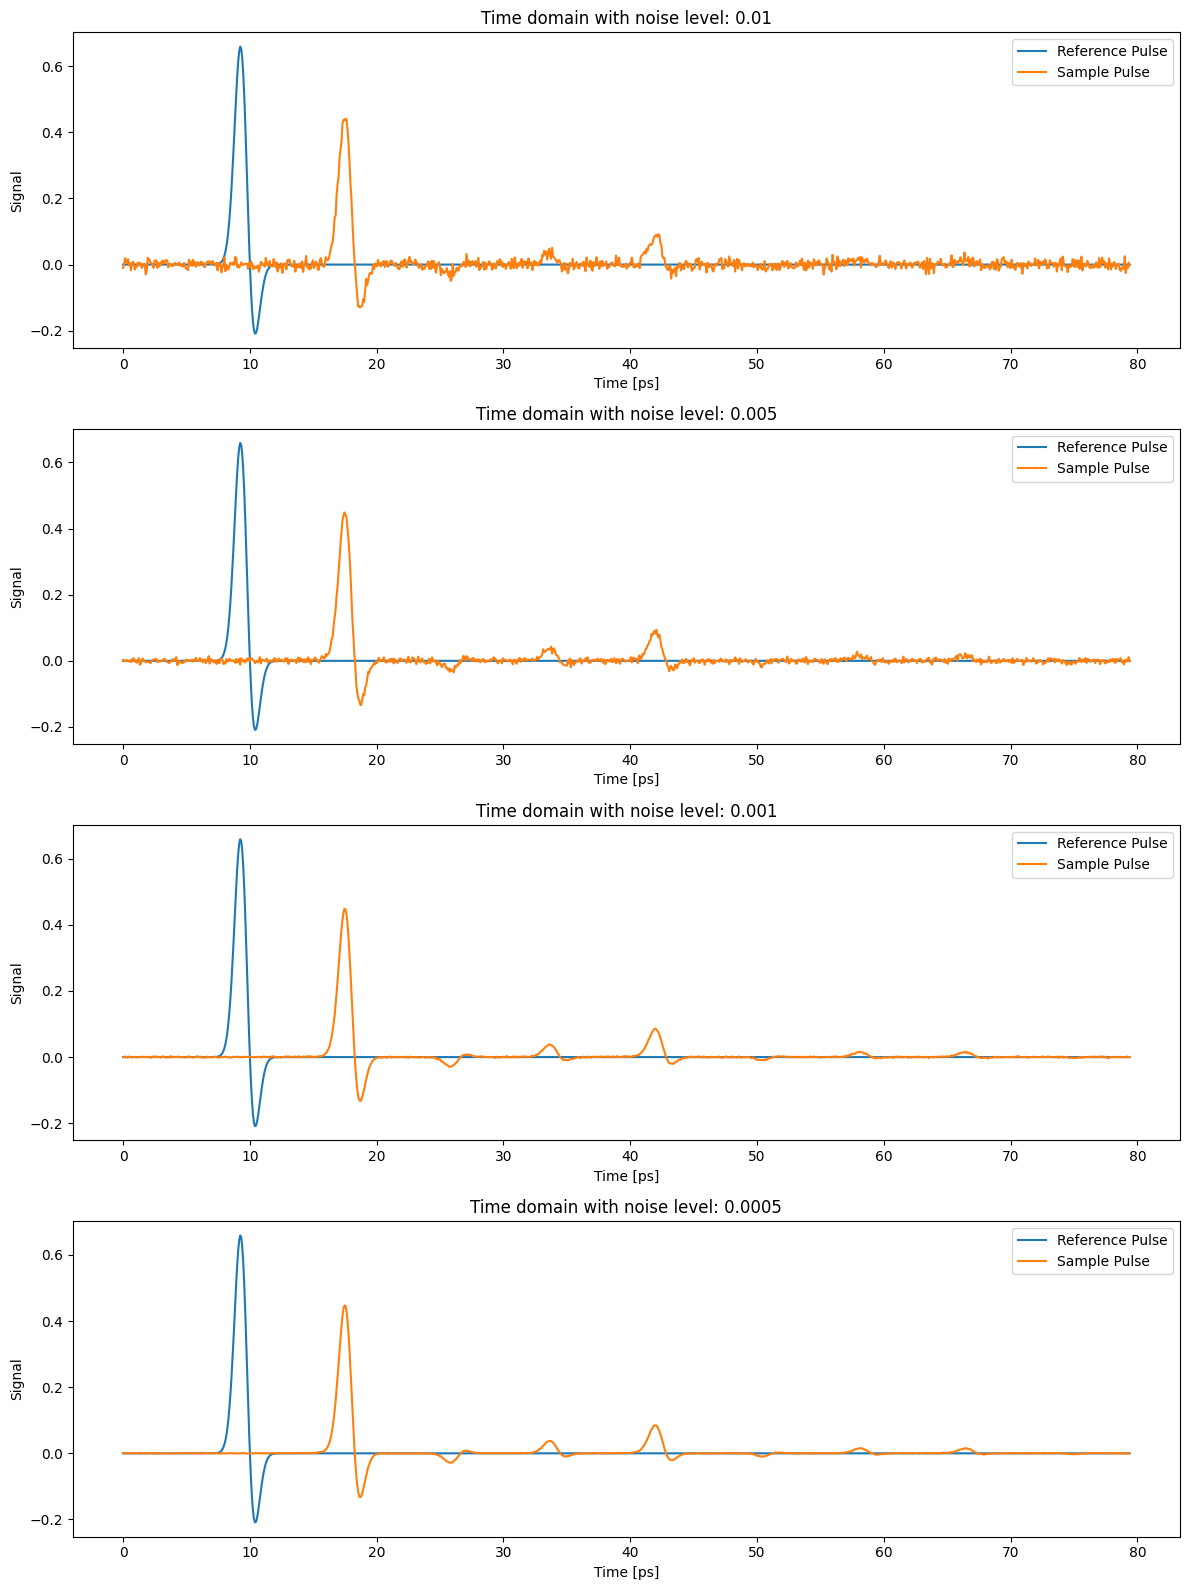

In [3]:
noise_levels = [1e-2, 0.5e-2, 1e-3, 0.5e-3]
down_sample_time = downsample_tensor(t_axis, 4)
down_sampled_ref = downsample_tensor(reference_pulse, 4)

pulses = [simulate_parallel(reference_pulse, material_params_exp, deltat, noise_level=noise_level)[1][:L].detach().numpy() for noise_level in noise_levels]
down_sampled_pulses = [downsample_tensor(pulse, 4) for pulse in pulses]

fig, axs = plt.subplots(len(pulses), 1, figsize=(12, 16)) 
for i in range(len(pulses)):
    axs[i].plot(down_sample_time*1e12, down_sampled_ref, label= 'Reference Pulse')
    axs[i].plot(down_sample_time*1e12, down_sampled_pulses[i], label='Sample Pulse')
    axs[i].set_xlabel('Time [ps]')
    axs[i].set_ylabel('Signal')
    axs[i].set_title(f'Time domain with noise level: {noise_levels[i]}')
    axs[i].legend()

plt.tight_layout()
plt.show()

In [4]:
2**12

4096

## Define reference and test downsampling
- Statice downsampling test to show functionality

In [5]:
# Example usage
downsampled_pulse = downsample_tensor(experimental_pulse, 4)

print("Original shape:", experimental_pulse.shape)
print("Downsampled shape:", downsampled_pulse.shape)

Original shape: torch.Size([4096])
Downsampled shape: torch.Size([1024])


In [6]:
t_axis_downsample = np.arange(0, L * deltat, deltat*4)

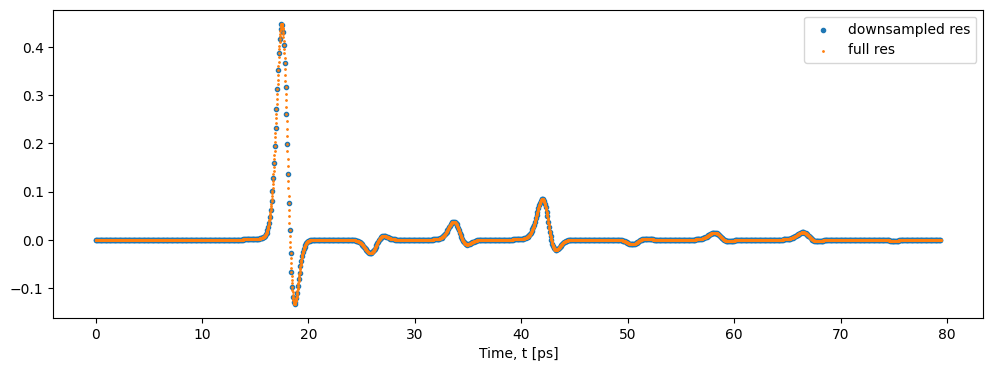

In [7]:
plt.figure(figsize=(12,4))
plt.scatter(t_axis_downsample*1e12, downsampled_pulse, label='downsampled res', s=9)
plt.scatter(t_axis*1e12, experimental_pulse, label='full res', s=1)
plt.xlabel('Time, t [ps]')
plt.legend()
plt.show()

## Now run Data_gen_efficient.py to get data 

In [13]:
# Load the dataset with weights_only=False
file_path = "Validation_noise_1eneg2.pt"

data = torch.load(f'data/{file_path}', weights_only=False)

# Extract components
synthetic_data = data["synthetic_data"]
material_params = data["material_params"]
num_layers = data["num_layers"]

print("Dataset loaded successfully!")
print(f"Number of samples: {len(synthetic_data)}")
print(f"Shape of synthetic_data: {synthetic_data.shape}")
print(f"Shape of num_layers: {num_layers.shape}")
print(f"Example number of layers: {num_layers[:10]}")

Dataset loaded successfully!
Number of samples: 10000
Shape of synthetic_data: torch.Size([10000, 1024])
Shape of num_layers: torch.Size([10000])
Example number of layers: tensor([3, 1, 2, 1, 1, 3, 3, 3, 1, 2])


In [14]:
import os
file_size = os.path.getsize(f'data/{file_path}')

file_size_MB = file_size / (1024*1024)

print(f'File size: {file_size_MB:.2f} MB')

File size: 41.59 MB


## Collect data, plot vs simulations to verify labels

Num layers: 3
Material parameters: [((2.2296830240627914-0.08175242721214412j), 0.00038473160589793027), ((5.3609248397557625-0.044066722464346744j), 0.0002287144300212674), ((2.922958851214696-0.05526535875717029j), 0.00037289239524251856)]


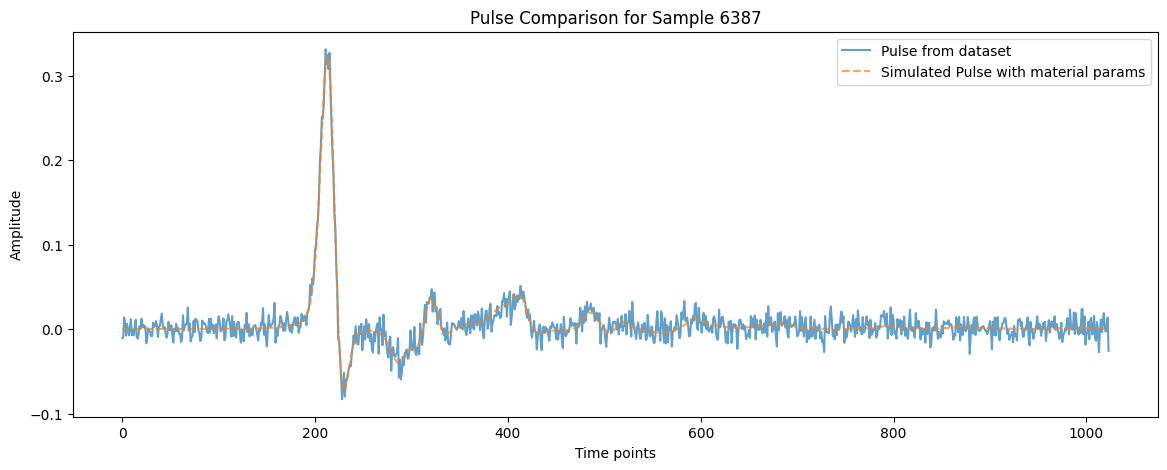

Sample 6387 comparison complete.
Num layers: 1
Material parameters: [((3.1334971655608745-0.05266189674687597j), 0.0001338950249087821)]


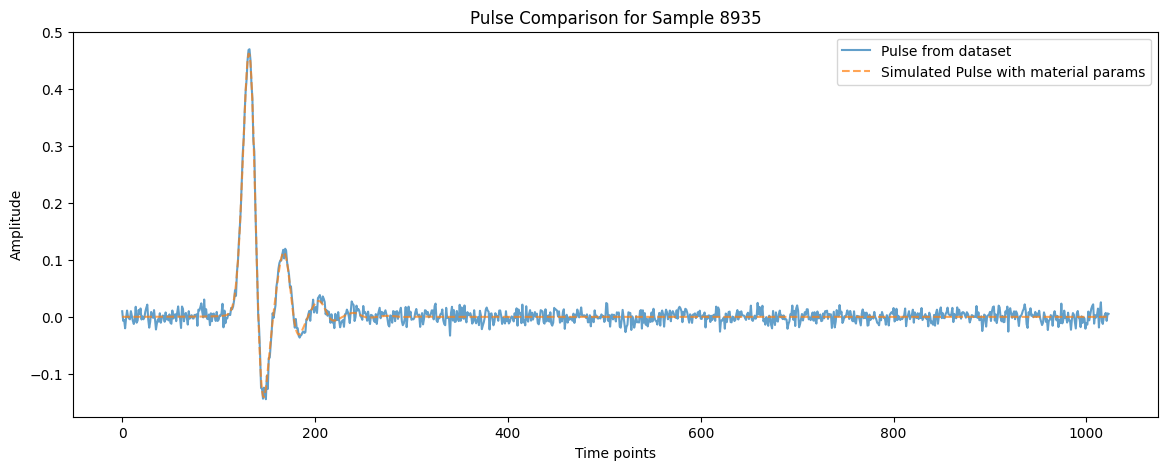

Sample 8935 comparison complete.
Num layers: 1
Material parameters: [((4.924753108003843-0.04386834337047119j), 9.217634173460203e-05)]


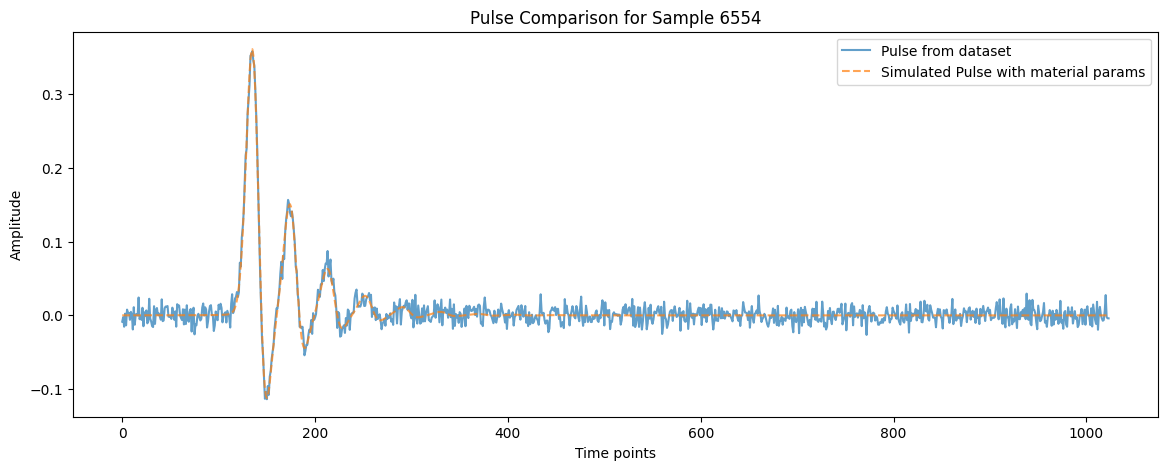

Sample 6554 comparison complete.
Num layers: 1
Material parameters: [((2.8698436388901305-0.015924927648731865j), 5.18795133928527e-05)]


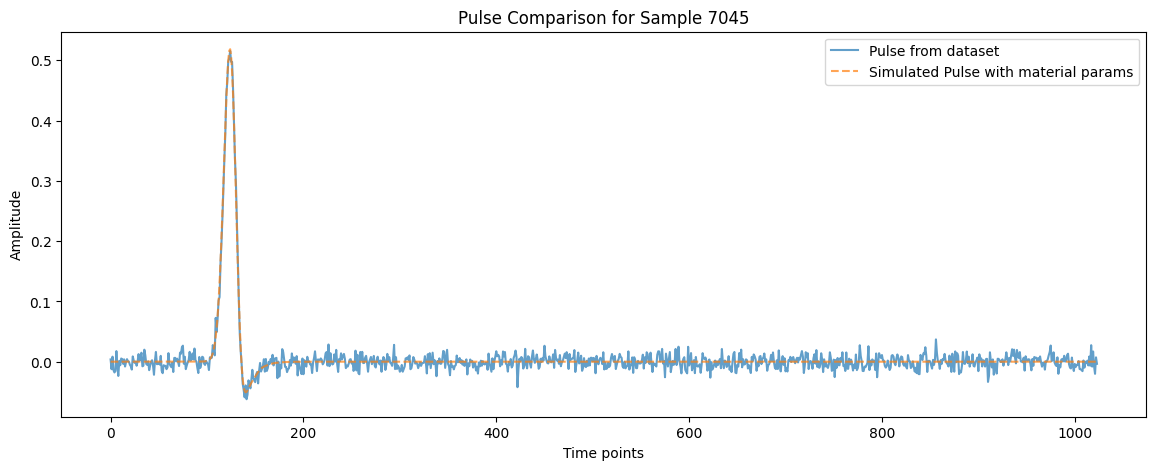

Sample 7045 comparison complete.
Num layers: 2
Material parameters: [((3.5466614764745343-0.02711344235956477j), 0.0004609929530065036), ((4.742297134382442-0.03978965361405734j), 0.0002490921169263863)]


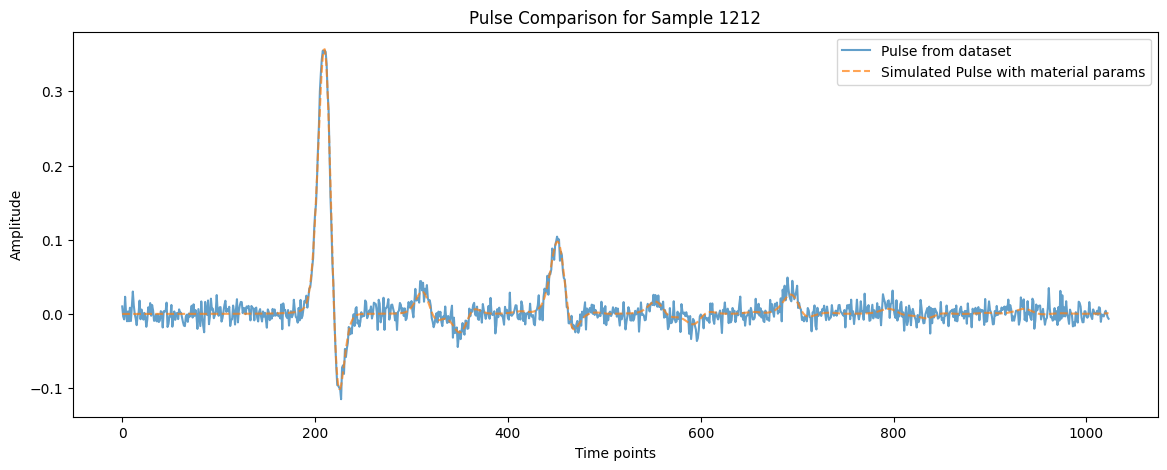

Sample 1212 comparison complete.


In [17]:
# Sample 5 random datapoints
num_samples = len(synthetic_data)
random_indices = np.random.choice(num_samples, 5, replace=False)

# Plot the pulses and compare them
for idx in random_indices:
    # Get the material parameters and the reference pulse for this sample
    material_sample = material_params[idx]
    print(f'Num layers: {len(material_sample)}')
    print(f'Material parameters: {material_sample}')
    # Simulate the pulse with the material parameters
    simulated_pulse = simulate_parallel(reference_pulse, material_sample, deltat, 0)[1].detach().cpu()[:L]
    simulated_pulse = downsample_tensor(simulated_pulse, 4)

    # Get the saved pulse from the dataset
    saved_pulse = synthetic_data[idx].cpu()


    # Plot both the simulated pulse and the saved pulse
    plt.figure(figsize=(14, 5))
    plt.plot(saved_pulse, label='Pulse from dataset', alpha=0.7)
    plt.plot(simulated_pulse, label='Simulated Pulse with material params', alpha=0.7, linestyle='--')
    plt.title(f"Pulse Comparison for Sample {idx}")
    plt.xlabel("Time points")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.show()

    print(f"Sample {idx} comparison complete.")